In [ ]:
# Lung Cancer Classification Demo
# This notebook demonstrates how to use the trained CNN model for lung cancer classification

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import pandas as pd
import kagglehub

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


In [ ]:
# Define the CNN model architecture (same as in train.ipynb)
class LungCancerCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(LungCancerCNN, self).__init__()

        # Convolutional layers with increased regularization
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        # Activation function
        self.relu = nn.ReLU()

        # Dropout layers with increasing rates for deeper layers
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Convolutional blocks with dropout
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout1(x)  # 224x224 -> 112x112

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout2(x)  # 112x112 -> 56x56

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout3(x)  # 56x56 -> 28x28

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout4(x)  # 28x28 -> 14x14

        # Flatten
        x = x.view(-1, 256 * 14 * 14)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout4(x)
        x = self.fc2(x)

        return x


In [ ]:
# Load the trained model
model = LungCancerCNN().to(device)
model.load_state_dict(torch.load('lung_cnn_state_dict.pth'))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully!")


In [ ]:
# Define image preprocessing function
def preprocess_image(image_path):
    """
    Preprocess an image for the model

    Args:
        image_path (str): Path to the image file

    Returns:
        torch.Tensor: Preprocessed image tensor
    """
    # Read and resize image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")

    img = cv2.resize(img, (224, 224))

    # Apply the same preprocessing as during training
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply transformations
    img_tensor = transform(img)

    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)

    return img_tensor


In [ ]:
# Function to make predictions on a single image
def predict_image(model, image_path, class_names):
    """
    Make a prediction on a single image

    Args:
        model (nn.Module): The trained model
        image_path (str): Path to the image file
        class_names (list): List of class names

    Returns:
        tuple: (predicted_class, confidence, class_probabilities)
    """
    # Preprocess the image
    img_tensor = preprocess_image(image_path)
    img_tensor = img_tensor.to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
        predicted_class = torch.argmax(probabilities).item()
        confidence = probabilities[predicted_class].item()

    return predicted_class, confidence, probabilities.cpu().numpy()


In [ ]:
# Function to visualize the prediction
def visualize_prediction(image_path, predicted_class, confidence, class_names):
    """
    Visualize an image with its prediction

    Args:
        image_path (str): Path to the image file
        predicted_class (int): Predicted class index
        confidence (float): Confidence score
        class_names (list): List of class names
    """
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    # Create figure
    plt.figure(figsize=(8, 8))
    plt.imshow(img)

    # Add prediction information
    plt.title(f"Prediction: {class_names[predicted_class]}\nConfidence: {confidence:.2f}", 
              fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Function to process multiple images and display results in a grid
def process_multiple_images(model, image_paths, class_names, num_cols=3):
    """
    Process multiple images and display results in a grid

    Args:
        model (nn.Module): The trained model
        image_paths (list): List of image file paths
        class_names (list): List of class names
        num_cols (int): Number of columns in the grid
    """
    num_images = len(image_paths)
    num_rows = (num_images + num_cols - 1) // num_cols  # Ceiling division

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
    axes = axes.flatten() if num_rows > 1 or num_cols > 1 else [axes]

    for i, image_path in enumerate(image_paths):
        if i < len(axes):
            # Make prediction
            predicted_class, confidence, _ = predict_image(model, image_path, class_names)

            # Read and display image
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i].imshow(img)
            axes[i].set_title(f"Pred: {class_names[predicted_class]}\nConf: {confidence:.2f}")
            axes[i].axis('off')

    # Hide any unused subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Download and access the dataset
path = kagglehub.dataset_download("adityamahimkar/iqothnccd-lung-cancer-dataset")
dataset_path = os.path.join(
    path,
    "The IQ-OTHNCCD lung cancer dataset",
    "The IQ-OTHNCCD lung cancer dataset"
)

# Define the class names (same as in train.ipynb)
class_names = ["Bengin cases", "Malignant cases", "Normal cases"]
print(f"Class names: {class_names}")


In [ ]:
# Demo 1: Predict on a single image from each class
print("Demo 1: Predicting on a single image from each class")

# Get one image from each class
demo_images = []
for category in class_names:
    folder_path = os.path.join(dataset_path, category)
    image_files = os.listdir(folder_path)
    if image_files:
        demo_images.append(os.path.join(folder_path, image_files[0]))

# Make predictions and visualize
for image_path in demo_images:
    predicted_class, confidence, _ = predict_image(model, image_path, class_names)
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f}")
    print("-" * 50)

    # Visualize
    visualize_prediction(image_path, predicted_class, confidence, class_names)


In [ ]:
# Demo 2: Process multiple random images
print("\nDemo 2: Processing multiple random images")

# Get random images from the dataset
import random
random.seed(42)  # For reproducibility

random_images = []
num_images_per_class = 3  # Number of images to select from each class

for category in class_names:
    folder_path = os.path.join(dataset_path, category)
    image_files = os.listdir(folder_path)
    selected_files = random.sample(image_files, min(num_images_per_class, len(image_files)))
    random_images.extend([os.path.join(folder_path, file) for file in selected_files])

# Process and display the images
process_multiple_images(model, random_images, class_names)



Demo 3: Using the predict_lung_cancer function
To use this function, call predict_lung_cancer(image_path)
Example:


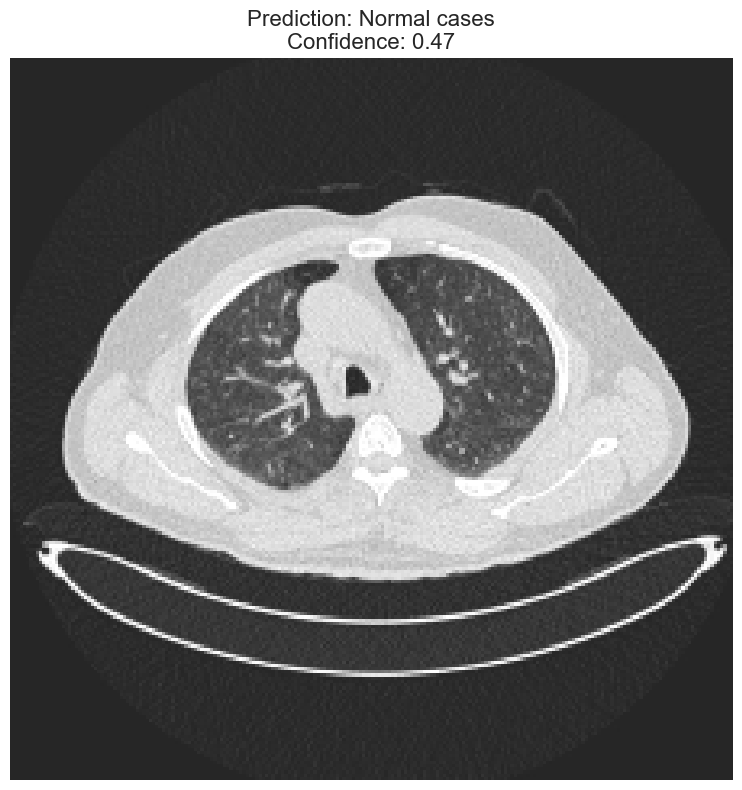

Prediction: Normal cases (Confidence: 0.47)


In [15]:
# Demo 3: Create a simple function to predict on a new image
def predict_lung_cancer(image_path):
    """
    User-friendly function to predict lung cancer from an image

    Args:
        image_path (str): Path to the image file

    Returns:
        str: Prediction result with confidence
    """
    try:
        predicted_class, confidence, _ = predict_image(model, image_path, class_names)
        result = f"Prediction: {class_names[predicted_class]} (Confidence: {confidence:.2f})"

        # Visualize
        visualize_prediction(image_path, predicted_class, confidence, class_names)

        return result
    except Exception as e:
        return f"Error processing image: {str(e)}"

# Example usage:
print("\nDemo 3: Using the predict_lung_cancer function")
print("To use this function, call predict_lung_cancer(image_path)")
print("Example:")
if demo_images:
    result = predict_lung_cancer(demo_images[0])
    print(result)



Demo 4: Visualizing the CNN Architecture and Workflow
Visualizing feature maps from convolutional layers...


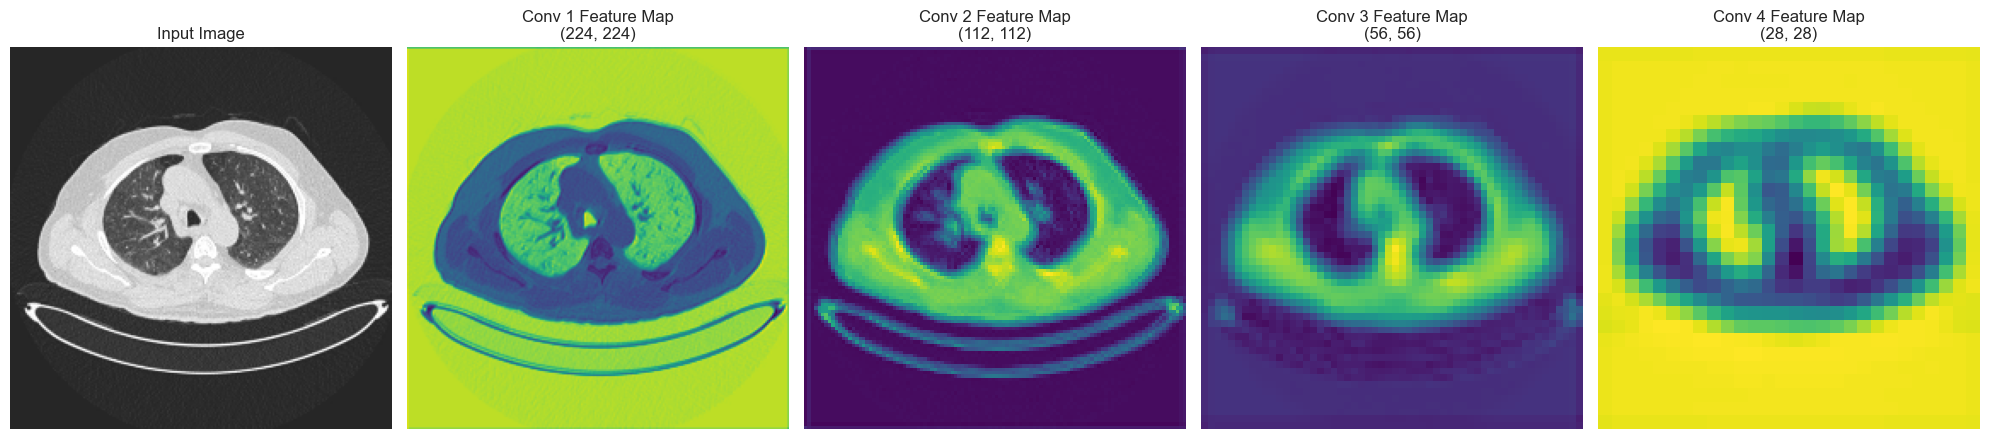


Visualizing CNN architecture...


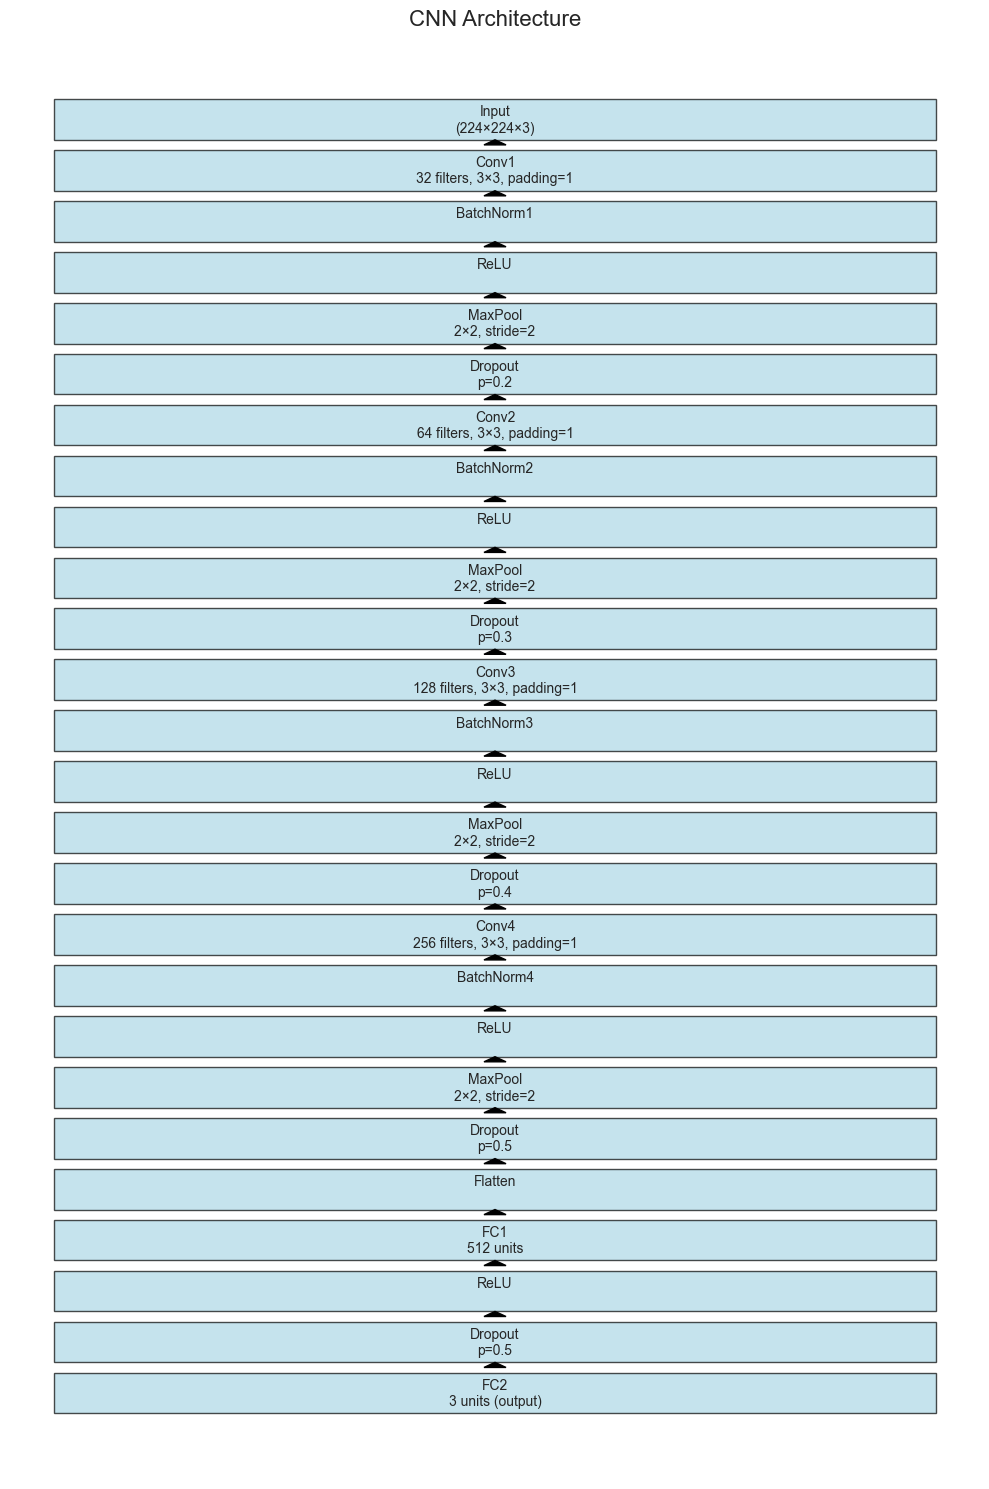


Creating model graph visualization...
Model graph saved as 'model_architecture.png'


In [16]:
# Demo 4: Visualize the CNN Architecture and Workflow
print("\nDemo 4: Visualizing the CNN Architecture and Workflow")

# Import necessary libraries
import torch.nn.functional as F
try:
    from torchviz import make_dot
    torchviz_available = True
except ImportError:
    print("Note: torchviz is not installed. Model graph visualization will be skipped.")
    print("To install: pip install torchviz")
    torchviz_available = False

def visualize_feature_maps(model, image_path):
    """
    Visualize feature maps from convolutional layers

    Args:
        model (nn.Module): The trained model
        image_path (str): Path to the image file
    """
    # Preprocess the image
    img_tensor = preprocess_image(image_path)
    img_tensor = img_tensor.to(device)

    # Dictionary to store feature maps
    feature_maps = {}

    # Hook function to capture feature maps
    def hook_fn(module, input, output):
        feature_maps[module] = output.detach()

    # Register hooks for convolutional layers
    hooks = []
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook_fn))

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(img_tensor)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Plot feature maps
    fig = plt.figure(figsize=(20, 10))

    # Plot input image
    plt.subplot(2, 5, 1)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')

    # Plot feature maps from each conv layer
    for idx, (layer, feat_map) in enumerate(feature_maps.items()):
        # Get first channel's feature map
        feat_map = feat_map[0, 0].cpu().numpy()

        plt.subplot(2, 5, idx + 2)
        plt.imshow(feat_map, cmap='viridis')
        plt.title(f'Conv {idx + 1} Feature Map\n{feat_map.shape}')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('cnn_visualization.png')
    plt.show()

# Visualize CNN architecture diagram
def visualize_cnn_architecture():
    """
    Create a text-based visualization of the CNN architecture
    """
    architecture = [
        ("Input", "(224×224×3)"),
        ("Conv1", "32 filters, 3×3, padding=1"),
        ("BatchNorm1", ""),
        ("ReLU", ""),
        ("MaxPool", "2×2, stride=2"),
        ("Dropout", "p=0.2"),
        ("Conv2", "64 filters, 3×3, padding=1"),
        ("BatchNorm2", ""),
        ("ReLU", ""),
        ("MaxPool", "2×2, stride=2"),
        ("Dropout", "p=0.3"),
        ("Conv3", "128 filters, 3×3, padding=1"),
        ("BatchNorm3", ""),
        ("ReLU", ""),
        ("MaxPool", "2×2, stride=2"),
        ("Dropout", "p=0.4"),
        ("Conv4", "256 filters, 3×3, padding=1"),
        ("BatchNorm4", ""),
        ("ReLU", ""),
        ("MaxPool", "2×2, stride=2"),
        ("Dropout", "p=0.5"),
        ("Flatten", ""),
        ("FC1", "512 units"),
        ("ReLU", ""),
        ("Dropout", "p=0.5"),
        ("FC2", "3 units (output)"),
    ]

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.axis('off')

    # Draw the architecture
    box_height = 0.8
    box_width = 8
    y_spacing = 1.0

    for i, (layer_name, layer_details) in enumerate(architecture):
        y_pos = -i * y_spacing

        # Draw box
        rect = plt.Rectangle((0, y_pos - box_height/2), box_width, box_height, 
                            facecolor='lightblue', edgecolor='black', alpha=0.7)
        ax.add_patch(rect)

        # Add text
        ax.text(box_width/2, y_pos, f"{layer_name}\n{layer_details}", 
                ha='center', va='center', fontsize=10)

        # Add arrow
        if i < len(architecture) - 1:
            ax.arrow(box_width/2, y_pos - box_height/2 - 0.1, 0, -y_spacing + box_height + 0.2,
                    head_width=0.2, head_length=0.1, fc='black', ec='black')

    plt.title('CNN Architecture', fontsize=16)
    plt.tight_layout()
    plt.savefig('cnn_architecture_diagram.png')
    plt.show()

# Visualize feature maps using a sample image
print("Visualizing feature maps from convolutional layers...")
if demo_images:
    visualize_feature_maps(model, demo_images[0])

# Visualize CNN architecture
print("\nVisualizing CNN architecture...")
visualize_cnn_architecture()

# Create model graph visualization using torchviz if available
if torchviz_available:
    print("\nCreating model graph visualization...")
    sample_input = torch.randn(1, 3, 224, 224).to(device)
    output = model(sample_input)
    dot = make_dot(output, params=dict(model.named_parameters()))
    dot.render("model_architecture", format="png")
    print("Model graph saved as 'model_architecture.png'")
